In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [5]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [6]:
start = time.time()
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )
print(f'Loading finished in {time.time()-start:.2f}s')

Found 1266345 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.
Loading finished in 1092.27s


In [24]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.EfficientNetB6(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
efficientnetb6 (Functional)  (None, 2, 2, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4720640   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0   

In [25]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

19787/19787 [==============================] - 10133s 511ms/step - loss: 1.3962 - auc_1: 0.8644 - val_loss: 1.7785 - val_auc_1: 0.7719


ROC AUC score: 0.7717312410515027


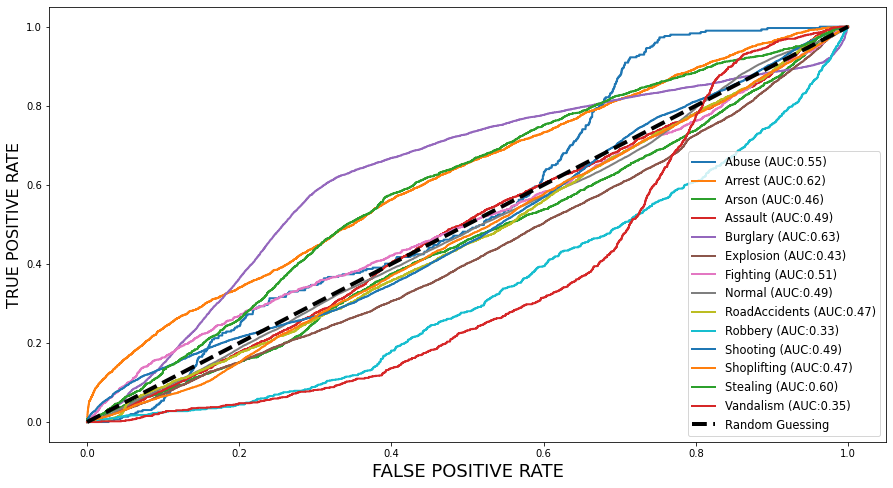

In [31]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [27]:
model.save('model2')

In [28]:
!zip -r file.zip /kaggle/working/model1

updating: kaggle/working/model1/ (stored 0%)
updating: kaggle/working/model1/keras_metadata.pb (deflated 96%)
updating: kaggle/working/model1/saved_model.pb (deflated 92%)
updating: kaggle/working/model1/assets/ (stored 0%)
updating: kaggle/working/model1/variables/ (stored 0%)
updating: kaggle/working/model1/variables/variables.index (deflated 79%)
updating: kaggle/working/model1/variables/variables.data-00000-of-00001 (deflated 7%)
